# Quadratic Flux Minimizing Surfaces

Quadratic-Flux-Minimizing (QFM) surfaces are a useful tool in vacuum stellarator optimization, where, given a coil magnetic field, one may extract a surface in space which minimizes the quadratic magnetic flux passing through it, that is,
$$
\begin{equation}
S = \argmin_S \int_S |B_n|^2 dS
\end{equation}
$$
Where $B_n = \mathbf{B} \cdot \mathbf{n}$ is the normal magnetic field on the surface $S$. The surface $S$ itself is described typically with two Fourier series in the poloidal and toroidal angles ([See the docs on basis functions for more details](../basis_grid.ipynb)) describing the cylindrical $R$ and $Z$ coordinates of the surface, so the optimization is done by varying the Fourier coefficients describing the surface (or potentially, the magnetic field's degrees of freedom as well). This short notebook will give an example of using QFM surfaces to extrace a surface from a magnetic field, and then solving the interior equilibrum with DESC and comparing it to the original magnetic field.

In [1]:
from desc.objectives import (
    QuadraticFluxMinimizingSurface,
    ToroidalFlux,
    ObjectiveFunction,
)
from desc.magnetic_fields import SplineMagneticField
from desc.geometry import FourierRZToroidalSurface
from desc.optimize import Optimizer
from desc.grid import LinearGrid
from desc.plotting import plot_2d, poincare_plot, plot_boundary, plot_surfaces
import numpy as np

DESC version 0.12.3+178.gd50fe0adb,using JAX backend, jax version=0.4.31, jaxlib version=0.4.30, dtype=float64
Using device: CPU, with 5.28 GB available memory


First, we will load a magnetic field from an ``mgrid`` file (the same as is used in the [stellarator free boundary notebook](./free_boundary_equilibrium.ipynb))

In [2]:
extcur = [4700.0, 1000.0]
field = SplineMagneticField.from_mgrid(
    "../../../tests/inputs/mgrid_test.nc", extcur=extcur
)

Our initial surface is a circular surface, which we see is not well-approximating any flux surfaces in this vacuum field.

(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

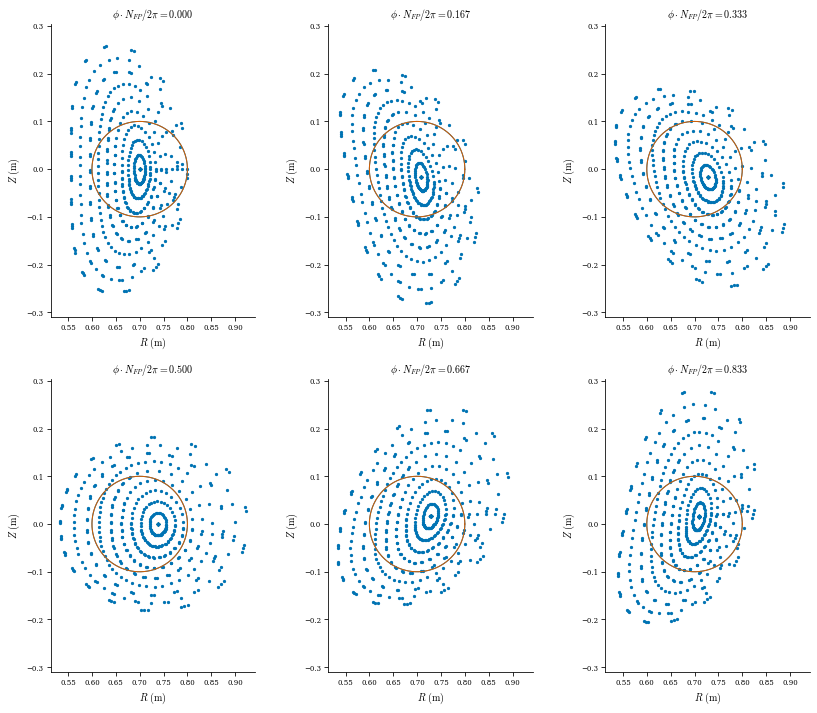

In [15]:
surface0 = FourierRZToroidalSurface(
    R_lmn=[0.7, 0.1],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-0.1],
    modes_Z=[[-1, 0]],
    sym=True,
    NFP=field.NFP,
    M=8,
    N=8,
)
fig, ax = plot_surfaces(surface0, rho=1.0, theta=0)
poincare_plot(
    field,
    R0=np.linspace(0.7, 0.8, 10),
    Z0=np.zeros(10),
    ax=ax,
    NFP=field.NFP,
    ntransit=50,
)

Let's setup the optimization problem to find the QFM surface.

In [16]:
# QuadraticFluxMinimizingSurface objective is the one to use when trying to minimize quadratic flux for a surface
qflux = QuadraticFluxMinimizingSurface(
    surface0,
    field,
    eval_grid=LinearGrid(M=2 * surface0.M, N=2 * surface0.M, NFP=surface0.NFP),
    field_fixed=True,
)  # field is not being optimized
# Must include a ToroidalFlux target to ensure we don't get a trivial solution of the surface collapsing to a point
target_psi = -0.035
tflux = ToroidalFlux(
    surface0,
    field,
    target=target_psi,  # the same toroidal flux as used in the free bdry eq
    qfm_surface=True,  # this flag is important so the objective knows we've passed a QFM surface and allows the surface to vary
    field_fixed=True,  # field is not being optimized
)
obj = ObjectiveFunction(qflux)

opt = Optimizer("lsq-auglag")

(qfm_surf,), _ = opt.optimize(
    surface0,
    objective=obj,
    constraints=(tflux,),
    ftol=1e-4,
    maxiter=500,
    verbose=3,
    copy=True,
)

Building objective: Quadratic Flux Minimizing Surface
Precomputing transforms
Timer: Precomputing transforms = 1.00 sec
Timer: Objective build = 1.00 sec
Building objective: toroidal-flux
Precomputing transforms
Timer: Precomputing transforms = 329 ms
Timer: Objective build = 630 ms
Number of parameters: 169
Number of objectives: 625
Number of equality constraints: 1
Number of inequality constraints: 0
Timer: Initializing the optimization = 1.66 sec

Starting optimization
Using method: lsq-auglag
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality    Constr viol.   Penalty param  max(|mltplr|) 
       0              1          6.632e+01                                    2.104e+03      1.383e-02      1.000e+01      0.000e+00   
       1              2          6.099e+01      5.329e+00      2.309e-03      2.006e+03      1.441e-02      1.000e+01      0.000e+00   
       2              3          4.257e+01      1.843e+01      9.279e-03      1.634e+03   

We can see that after the optimization, the normal field error is quite small

(<Figure size 432.324x432.324 with 2 Axes>,
 <Axes: title={'center': '$\\mathbf{B} \\cdot \\hat{n} ~(\\mathrm{T})$'}, xlabel='$\\zeta$', ylabel='$\\theta$'>)

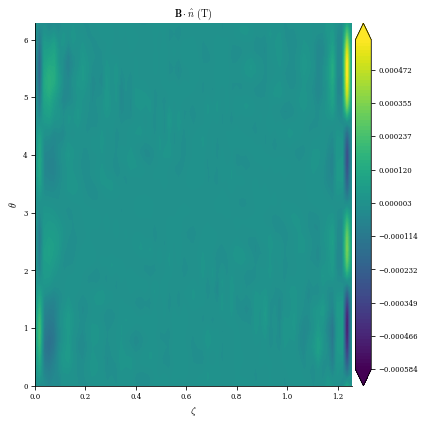

In [18]:
plot_2d(qfm_surf, "B*n", field=field, cmap="viridis")

We also see that the optimized surface is now a good approximation of a flux surface in this vacuum field

(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

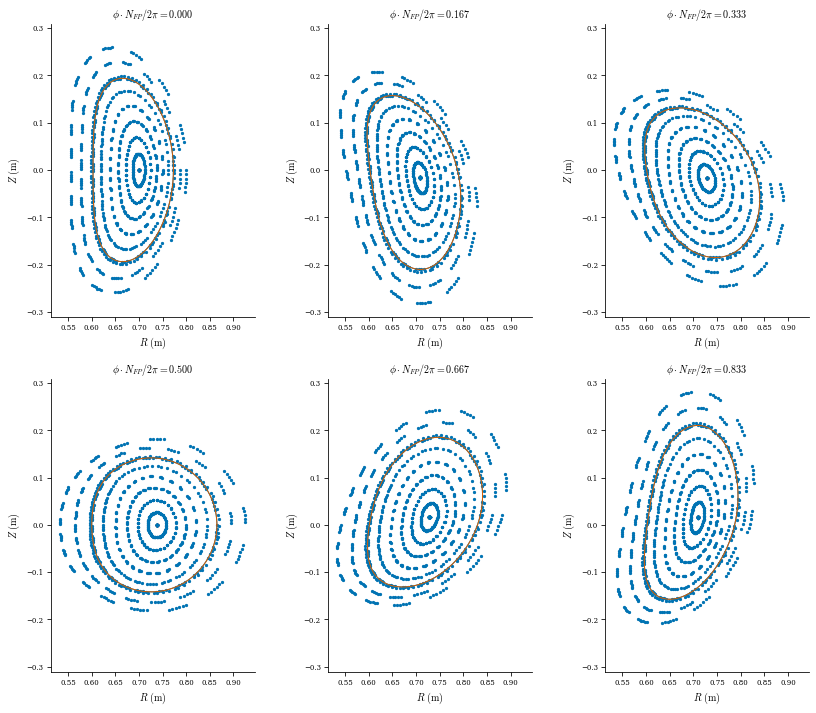

In [19]:
data = qfm_surf.compute(["R", "Z"], grid=LinearGrid(rho=1.0, theta=0, zeta=0))
fig, ax = plot_surfaces(qfm_surf, rho=1.0, theta=0)
poincare_plot(
    field, R0=np.append(data["R"], np.linspace(0.7, 0.8, 9)), Z0=np.zeros(10), ax=ax
)

We can use this QFM surface as the surface for a fixed-boundary DESC equilibrium solve, to find the equilibrium field which matches the vacuum field inside this surface. (Alternatively, one could also perform a free-boundary solve, though we know the surface should not change much from this QFM surface)

In [20]:
from desc.equilibrium import Equilibrium

eq = Equilibrium(surface=qfm_surf, Psi=-0.035, L=8, M=8, N=8)
eq.solve(verbose=3, ftol=1e-5);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 40.4 ms
Timer: Objective build = 53.5 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 98.3 ms
Timer: Linear constraint projection build = 2.59 sec
Number of parameters: 856
Number of objectives: 5346
Timer: Initializing the optimization = 2.77 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          4.154e-01                                    2.717e+02   
       1              2          2.214e-02      3.933e-01      2.464

Finally, we compare the solve equilibrium's flux surfaces with the vacuum field Poincare plot and confirm that indeed, the equilibrium matches the vacuum field as expected.

(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

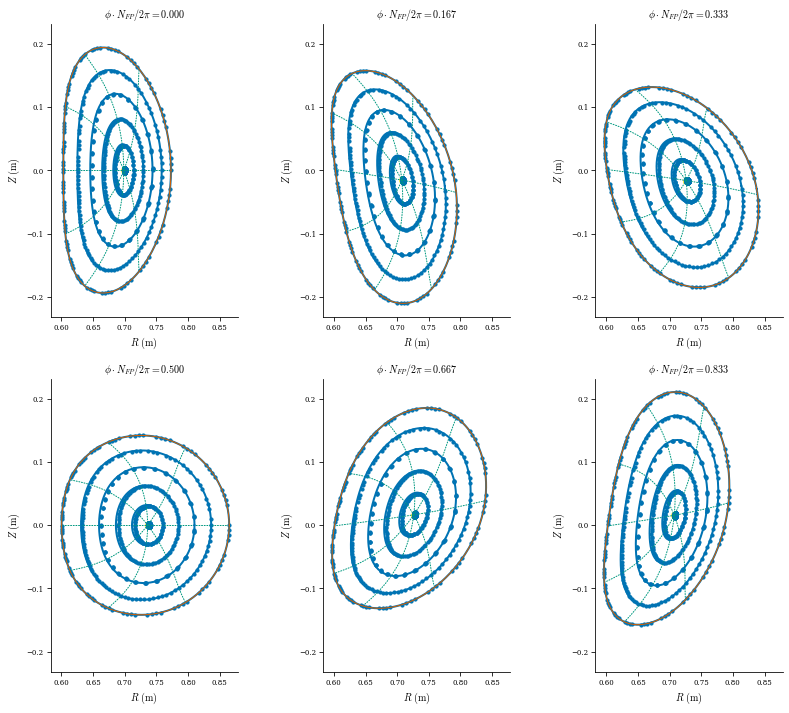

In [21]:
grid = LinearGrid(L=5)
data = eq.compute(["R", "Z"], grid=grid)
fig, ax = plot_surfaces(eq, rho=grid.nodes[:, 0], rho_lw=2)
poincare_plot(field, R0=data["R"], Z0=data["Z"], ax=ax, NFP=eq.NFP, size=10)